In [191]:
import os
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import torch
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import skew, spearmanr
import shap
from sktime.transformations.panel.rocket import Rocket
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from torch import nn
from torch.nn.utils import weight_norm

from sklearn.model_selection import train_test_split, KFold, LeavePGroupsOut, LeaveOneGroupOut, LeaveOneOut
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from tabpfn import TabPFNRegressor
from sklearn.cluster import KMeans

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
print("Device being used:", device, flush=True)

seed = 69
np.random.seed(seed)
torch.manual_seed(seed)


Device being used: cuda


In [192]:
data = pd.read_csv('all-features-imputed-v2.csv')

display(data)
display(data.columns.to_list())


acceleration    = data.filter(like='acceleration').columns.tolist()
heartrate       = data.filter(like='heartrate').filter(regex='^(?!.*sleep)').columns.tolist()
motion          = data.filter(like='motion').columns.tolist()
position        = data.filter(like='position').columns.tolist()
sleep           = data.filter(like='sleep').columns.tolist()
step            = data.filter(like='step').columns.tolist()
demographics    = ['sex', 'age']



display(acceleration)
display(heartrate)
display(motion)
display(position)
display(sleep)
display(step)




,participant,timestamp,clinical-timestamp,sis-01,sis-02,sis-03,sis-04,sis-05,sis-06,sis,...,step-mean,step-max,step-max-timestamp,sex,age,fracture-type,relationship,education,work,ethnicity
0,1,3/31/2022,4/13/2022,5,5,4,4,5,2,25,...,34.5833,106.0000,13.0000,-1,74,-1,1,1,-1,1
1,1,4/1/2022,4/13/2022,5,5,4,4,5,2,25,...,63.8571,185.0000,8.0000,-1,74,-1,1,1,-1,1
2,1,4/2/2022,4/13/2022,5,5,4,4,5,2,25,...,56.1132,169.7692,13.5385,-1,74,-1,1,1,-1,1
3,1,4/3/2022,4/13/2022,5,5,4,4,5,2,25,...,106.0000,288.0000,22.0000,-1,74,-1,1,1,-1,1
4,1,4/4/2022,4/13/2022,5,5,4,4,5,2,25,...,76.2222,176.0000,11.0000,-1,74,-1,1,1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555,10,12/14/2024,12/18/2024,3,5,3,2,3,2,18,...,34.7143,131.0000,17.0000,1,77,3,1,-1,-1,-1
556,10,12/15/2024,12/18/2024,3,5,3,2,3,2,18,...,152.2000,916.0000,14.0000,1,77,3,1,-1,-1,-1
557,10,12/16/2024,12/18/2024,3,5,3,2,3,2,18,...,84.0909,326.0000,17.0000,1,77,3,1,-1,-1,-1
558,10,12/17/2024,12/18/2024,3,5,3,2,3,2,18,...,62.6667,192.0000,11.0000,1,77,3,1,-1,-1,-1


['participant',
 'timestamp',
 'clinical-timestamp',
 'sis-01',
 'sis-02',
 'sis-03',
 'sis-04',
 'sis-05',
 'sis-06',
 'sis',
 'ohs-01',
 'ohs-02',
 'ohs-03',
 'ohs-04',
 'ohs-05',
 'ohs-06',
 'ohs-07',
 'ohs-08',
 'ohs-09',
 'ohs-10',
 'ohs-11',
 'ohs-12',
 'ohs',
 'oks-01',
 'oks-02',
 'oks-03',
 'oks-04',
 'oks-05',
 'oks-06',
 'oks-07',
 'oks-08',
 'oks-09',
 'oks-10',
 'oks-11',
 'oks-12',
 'oks',
 'tug',
 'chairstand',
 'acceleration-count',
 'acceleration-mean',
 'acceleration-std',
 'acceleration-sum',
 'acceleration-entropy',
 'acceleration-kurtosis',
 'acceleration-skew',
 'acceleration-coefficient-of-variation',
 'acceleration-minutes-with-data',
 'acceleration-hours-with-data',
 'acceleration-movement-events-00to06',
 'acceleration-movement-events-06to12',
 'acceleration-movement-events-12to18',
 'acceleration-movement-events-18to24',
 'acceleration-movement-events-24h',
 'acceleration-intradaily-variability',
 'heartrate-count',
 'heartrate-min',
 'heartrate-max',
 'heart

['acceleration-count',
 'acceleration-mean',
 'acceleration-std',
 'acceleration-sum',
 'acceleration-entropy',
 'acceleration-kurtosis',
 'acceleration-skew',
 'acceleration-coefficient-of-variation',
 'acceleration-minutes-with-data',
 'acceleration-hours-with-data',
 'acceleration-movement-events-00to06',
 'acceleration-movement-events-06to12',
 'acceleration-movement-events-12to18',
 'acceleration-movement-events-18to24',
 'acceleration-movement-events-24h',
 'acceleration-intradaily-variability']

['heartrate-count',
 'heartrate-min',
 'heartrate-max',
 'heartrate-mean',
 'heartrate-std',
 'heartrate-hours-with-data']

['motion-count',
 'motion-ratio',
 'motion-mean',
 'motion-max',
 'motion-max-timestamp']

['position-count',
 'position-mean',
 'position-max',
 'position-duration',
 'position-travelled-distance']

['sleep-total',
 'sleep-deep',
 'sleep-light',
 'sleep-rem',
 'sleep-snoring-duration',
 'sleep-duration-to-sleep',
 'sleep-duration-to-wakeup',
 'sleep-wakeup-count',
 'sleep-heartrate-mean',
 'sleep-heartrate-min',
 'sleep-heartrate-max']

['step-count', 'step-ratio', 'step-mean', 'step-max', 'step-max-timestamp']

In [193]:
modalities = acceleration + heartrate + motion + position + sleep + step
sensor = data[modalities]

sis = data['sis']
participant = data['participant']

x = np.array(sensor)
y = np.array(sis)
p = np.array(participant)

display(x.shape, y.shape, p.shape)

(560, 48)

(560,)

(560,)

Fold 1: train=448 test=112
Fold 2: train=448 test=112
Fold 3: train=448 test=112
Fold 4: train=448 test=112
Fold 5: train=448 test=112


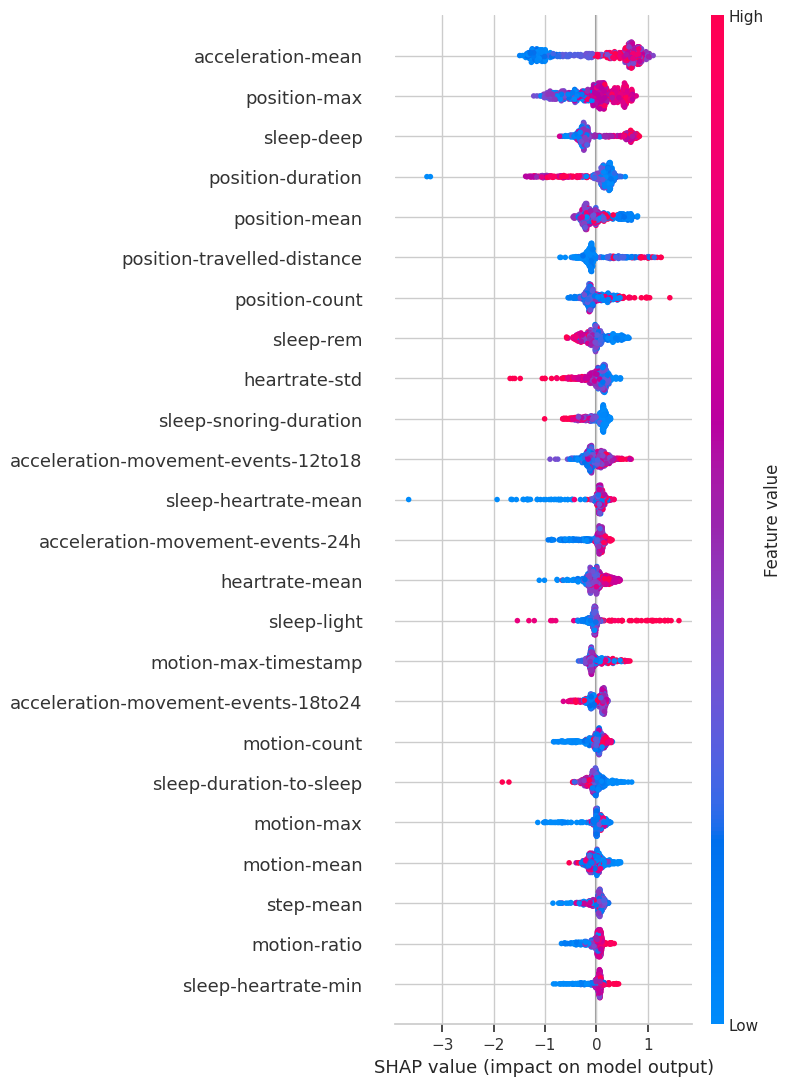

In [194]:
Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])
SHAP = []
X_TEST = []

cv = KFold(n_splits=5, shuffle=True, random_state=seed)
for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):
    
    print(f"Fold {fold}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)

    normalizer = MinMaxScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test = normalizer.transform(x_test)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )

    model.fit(x_train, y_train, eval_set=(x_train, y_train), use_best_model=True, early_stopping_rounds=100)
    y_preds = model.predict(x_test)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(x_test)

    SHAP.append(shap_values)
    X_TEST.append(x_test)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)


shap_df = pd.DataFrame({
    'feature': modalities,
    'mean_abs_shap': np.abs(np.vstack(SHAP)).mean(axis=0).round(4)
}).sort_values(by='mean_abs_shap', ascending=False)
# display(shap_df)
shap.summary_plot(np.vstack(SHAP), pd.DataFrame(np.vstack(X_TEST), columns=modalities), max_display=24)




# Select the first num_features features based on SHAP importance + demographics
num_features = 64
x = np.array(data[
    shap_df['feature'].iloc[:num_features].to_list()
    # + demographics
    ])



In [195]:
grouped = data.groupby(['clinical-timestamp', 'participant'], sort=False)

most_common_features_16 = ['acceleration-mean', 'heartrate-std', 'position-count', 'position-mean', 'position-max', 'position-duration', 'position-travelled-distance', 'sleep-deep', 'motion-mean', 'sleep-heartrate-mean', 'motion-count', 'motion-max', 'sleep-rem', 'acceleration-movement-events-24h', 'sleep-light', 'acceleration-movement-events-18to24']
most_common_features_24 = ['acceleration-mean', 'acceleration-movement-events-12to18', 'heartrate-std', 'motion-count', 'motion-mean', 'position-count', 'position-mean', 'position-max', 'position-duration', 'position-travelled-distance', 'sleep-deep', 'sleep-light', 'sleep-rem', 'sleep-heartrate-mean', 'acceleration-minutes-with-data', 'acceleration-movement-events-00to06', 'acceleration-movement-events-18to24', 'motion-max', 'sleep-snoring-duration', 'sleep-heartrate-min', 'step-mean', 'acceleration-movement-events-24h', 'motion-max-timestamp', 'heartrate-mean']



y = []
p = []
x = []

num_features = 16

for name, group in grouped:

    sis = group['sis'].iloc[0]
    participant = group['participant'].iloc[0].item()
    group = group[
        # shap_df['feature'].iloc[:num_features].to_list()
        most_common_features_24
        # + demographics
        ]

    # weekly
    y.append(sis)
    p.append(participant)
    x.append(group.iloc[:7])
    
    y.append(sis)
    p.append(participant)
    x.append(group.iloc[7:])

    # biweekly
    # y.append(sis)
    # p.append(participant)
    # x.append(group)

x = np.array(x)
y = np.array(y)
p = np.array(p)

display(x.shape, y.shape, p.shape)

(80, 7, 24)

(80,)

(80,)

Fold 1: train=64 test=16
Fold 2: train=64 test=16
Fold 3: train=64 test=16
Fold 4: train=64 test=16
Fold 5: train=64 test=16


mae,mse,r2_score,correlation
2.2217,7.8603,0.2510,0.5754


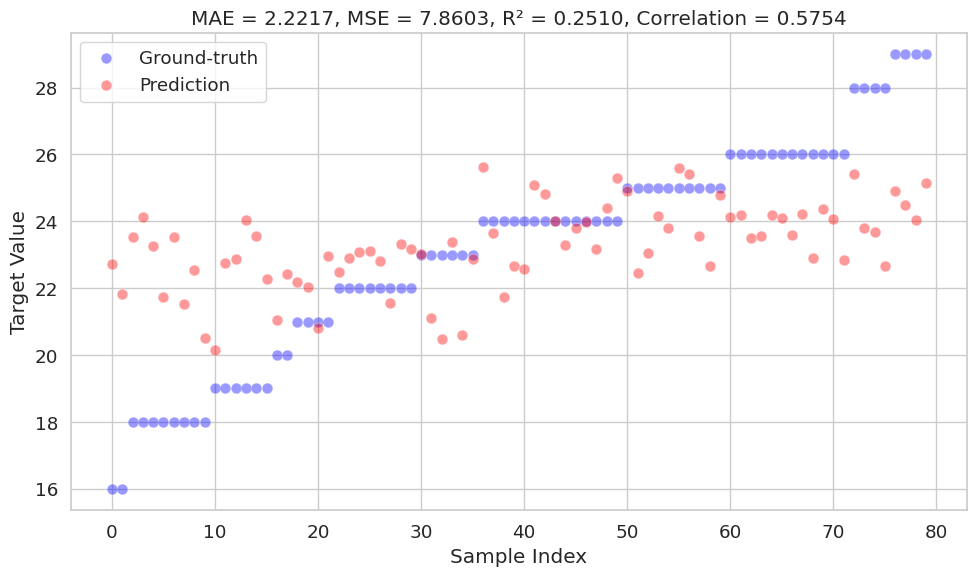

In [ ]:
# ROCKET -- CatBoost

Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])

# cv = LeaveOneOut()
# for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

# cv = LeaveOneGroupOut()
# for fold, (train_idx, test_idx) in enumerate(cv.split(x, y, groups=p), start=1):

cv = KFold(n_splits=5, shuffle=True, random_state=seed)
for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

    print(f"Fold {fold}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]



    # Standardaizetion-Normalization
    x_train_2d = x_train.reshape(-1, x_train.shape[2])
    x_test_2d = x_test.reshape(-1, x_test.shape[2])

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_2d)
    x_test_scaled = scaler.transform(x_test_2d)

    normalizer = MinMaxScaler()
    x_train_normalized = normalizer.fit_transform(x_train_scaled)
    x_test_normalized = normalizer.transform(x_test_scaled)

    x_train = x_train_normalized.reshape(x_train.shape[0], x_train.shape[1], -1)
    x_test = x_test_normalized.reshape(x_test.shape[0], x_test.shape[1], -1)


    # ----- ROCKET - Catboost
    rocket = Rocket(num_kernels=1_000)
    rocket.fit(x_train)
    x_train_transformed = rocket.transform(x_train)
    x_test_transformed = rocket.transform(x_test)

    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )
    
    model.fit(x_train_transformed, y_train,
              eval_set=(x_train_transformed, y_train),
            #   eval_set=(x_test_transformed, y_test),              
              use_best_model=True, early_stopping_rounds=100)
    
    y_preds = model.predict(x_test_transformed)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)

indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PREDS = Y_PREDS[indx]

mae = mean_absolute_error(Y_TRUES, Y_PREDS)
mse = mean_squared_error(Y_TRUES, Y_PREDS)
r2 = r2_score(Y_TRUES, Y_PREDS)
corr, _ = spearmanr(Y_TRUES, Y_PREDS)

results = {
    'mae': f"{mae:.4f}",
    'mse': f"{mse:.4f}",
    'r2_score': f"{r2:.4f}",
    'correlation': f"{corr:.4f}"
}

results = pd.DataFrame([results])
display(results.style.hide(axis='index'))

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(Y_TRUES)), y=Y_TRUES, label='Ground-truth', color='blue', alpha=0.4, s=60)
sns.scatterplot(x=range(len(Y_PREDS)), y=Y_PREDS, label='Prediction', color='red', alpha=0.4, s=60)

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f"MAE = {mae:.4f}, MSE = {mse:.4f}, R² = {r2:.4f}, Correlation = {corr:.4f}")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Fold 1: train=64 test=16
Fold 2: train=64 test=16
Fold 3: train=64 test=16
Fold 4: train=64 test=16
Fold 5: train=64 test=16


mae,mse,r2_score,correlation
1.7728,5.3427,0.4909,0.7277


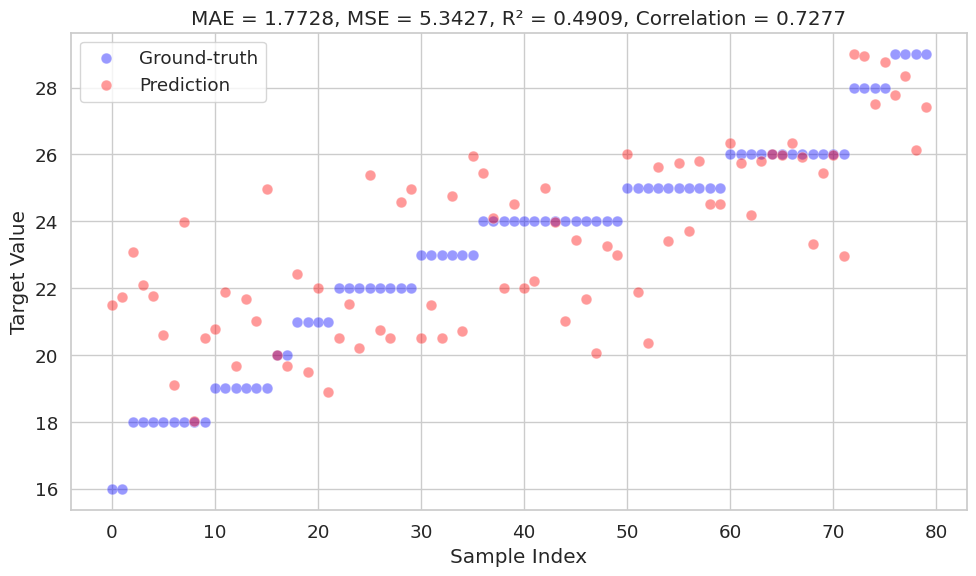

In [197]:
# Bag-of-Words - CatBoost

from statsmodels.tools.eval_measures import mse

def histogram(inputs, num_bins):
    counts = np.zeros(num_bins)
    for input in inputs:
        for i in range(num_bins):
            if input == i:
                counts[i] += 1
    return counts



Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])

# cv = LeaveOneOut()
# for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

# cv = LeaveOneGroupOut()
# for fold, (train_idx, test_idx) in enumerate(cv.split(x, y, groups=p), start=1):

cv = KFold(n_splits=5, shuffle=True, random_state=seed)
for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

    print(f"Fold {fold}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]



    # Standardaizetion-Normalization
    x_train_2d = x_train.reshape(-1, x_train.shape[2])
    x_test_2d = x_test.reshape(-1, x_test.shape[2])

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_2d)
    x_test_scaled = scaler.transform(x_test_2d)

    normalizer = MinMaxScaler()
    x_train_normalized = normalizer.fit_transform(x_train_scaled)
    x_test_normalized = normalizer.transform(x_test_scaled)

    x_train = x_train_normalized.reshape(x_train.shape[0], x_train.shape[1], -1)
    x_test = x_test_normalized.reshape(x_test.shape[0], x_test.shape[1], -1)


    # ----- Bag-of-Words - CatBoost
    n_clusters = 16

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=seed).fit(x_train_normalized)
    centers = kmeans.cluster_centers_

    hist_train = []
    for fs in x_train:
        indices = []
        for f in fs:
            indices.append(np.argmin([mse(f, center) for center in centers]))
        h = histogram(indices, centers.shape[0])
        hist_train.append(h)
    hist_train = np.array(hist_train)

    hist_test = []
    for fs in x_test:
        indices = []
        for f in fs:
            indices.append(np.argmin([mse(f, center) for center in centers]))
        h = histogram(indices, centers.shape[0])
        hist_test.append(h)
    hist_test = np.array(hist_test)


    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=.1,
        depth=3,
        loss_function='RMSE',
        verbose=False
    )
    
    model.fit(hist_train, y_train,
              eval_set=(hist_train, y_train),
            #   eval_set=(hist_test, y_test),              
              use_best_model=True, early_stopping_rounds=100)
    
    y_preds = model.predict(hist_test)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)

indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PREDS = Y_PREDS[indx]

mae = mean_absolute_error(Y_TRUES, Y_PREDS)
MSE = mean_squared_error(Y_TRUES, Y_PREDS)
r2 = r2_score(Y_TRUES, Y_PREDS)
corr, _ = spearmanr(Y_TRUES, Y_PREDS)

results = {
    'mae': f"{mae:.4f}",
    'mse': f"{MSE:.4f}",
    'r2_score': f"{r2:.4f}",
    'correlation': f"{corr:.4f}"
}

results = pd.DataFrame([results])
display(results.style.hide(axis='index'))

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(Y_TRUES)), y=Y_TRUES, label='Ground-truth', color='blue', alpha=0.4, s=60)
sns.scatterplot(x=range(len(Y_PREDS)), y=Y_PREDS, label='Prediction', color='red', alpha=0.4, s=60)

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f"MAE = {mae:.4f}, MSE = {MSE:.4f}, R² = {r2:.4f}, Correlation = {corr:.4f}")
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Fold 1: train=64 test=16
Fold 2: train=64 test=16
Fold 3: train=64 test=16
Fold 4: train=64 test=16
Fold 5: train=64 test=16


mae,mse,r2_score,correlation
1.9311,6.7301,0.3587,0.6908


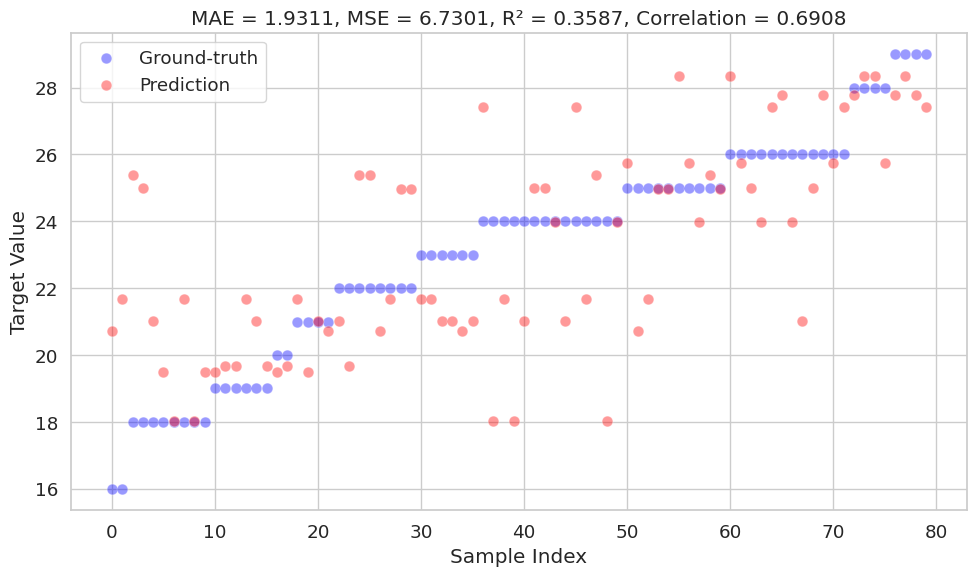

In [198]:
# Bag-of-Words - TabPFN

from statsmodels.tools.eval_measures import mse

def histogram(inputs, num_bins):
    counts = np.zeros(num_bins)
    for input in inputs:
        for i in range(num_bins):
            if input == i:
                counts[i] += 1
    return counts



Y_TRUES = np.empty([0])
Y_PREDS = np.empty([0])

# cv = LeaveOneOut()
# for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

# cv = LeaveOneGroupOut()
# for fold, (train_idx, test_idx) in enumerate(cv.split(x, y, groups=p), start=1):

cv = KFold(n_splits=5, shuffle=True, random_state=seed)
for fold, (train_idx, test_idx) in enumerate(cv.split(x), start=1):

    print(f"Fold {fold}: train={len(train_idx)} test={len(test_idx)}")

    x_train, x_test = x[train_idx], x[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]



    # Standardaizetion-Normalization
    x_train_2d = x_train.reshape(-1, x_train.shape[2])
    x_test_2d = x_test.reshape(-1, x_test.shape[2])

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train_2d)
    x_test_scaled = scaler.transform(x_test_2d)

    normalizer = MinMaxScaler()
    x_train_normalized = normalizer.fit_transform(x_train_scaled)
    x_test_normalized = normalizer.transform(x_test_scaled)

    x_train = x_train_normalized.reshape(x_train.shape[0], x_train.shape[1], -1)
    x_test = x_test_normalized.reshape(x_test.shape[0], x_test.shape[1], -1)


    # ----- Bag-of-Words - TabPFN
    n_clusters = 16

    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=seed).fit(x_train_normalized)
    centers = kmeans.cluster_centers_

    hist_train = []
    for fs in x_train:
        indices = []
        for f in fs:
            indices.append(np.argmin([mse(f, center) for center in centers]))
        h = histogram(indices, centers.shape[0])
        hist_train.append(h)
    hist_train = np.array(hist_train)

    hist_test = []
    for fs in x_test:
        indices = []
        for f in fs:
            indices.append(np.argmin([mse(f, center) for center in centers]))
        h = histogram(indices, centers.shape[0])
        hist_test.append(h)
    hist_test = np.array(hist_test)


    model = TabPFNRegressor(
        device='cuda',
        random_state=seed,
        n_estimators = 4,
        ignore_pretraining_limits=True)
    model.fit(hist_train, y_train)
    y_probs = model.predict(hist_test)

    Y_TRUES = np.append(Y_TRUES, y_test)
    Y_PREDS = np.append(Y_PREDS, y_preds)

indx = Y_TRUES.argsort()
Y_TRUES = Y_TRUES[indx]
Y_PREDS = Y_PREDS[indx]

mae = mean_absolute_error(Y_TRUES, Y_PREDS)
MSE = mean_squared_error(Y_TRUES, Y_PREDS)
r2 = r2_score(Y_TRUES, Y_PREDS)
corr, _ = spearmanr(Y_TRUES, Y_PREDS)

results = {
    'mae': f"{mae:.4f}",
    'mse': f"{MSE:.4f}",
    'r2_score': f"{r2:.4f}",
    'correlation': f"{corr:.4f}"
}

results = pd.DataFrame([results])
display(results.style.hide(axis='index'))

sns.set(style="whitegrid", font_scale=1.2)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(Y_TRUES)), y=Y_TRUES, label='Ground-truth', color='blue', alpha=0.4, s=60)
sns.scatterplot(x=range(len(Y_PREDS)), y=Y_PREDS, label='Prediction', color='red', alpha=0.4, s=60)

plt.xlabel('Sample Index')
plt.ylabel('Target Value')
plt.title(f"MAE = {mae:.4f}, MSE = {MSE:.4f}, R² = {r2:.4f}, Correlation = {corr:.4f}")
plt.legend(loc='best')
plt.tight_layout()
plt.show()